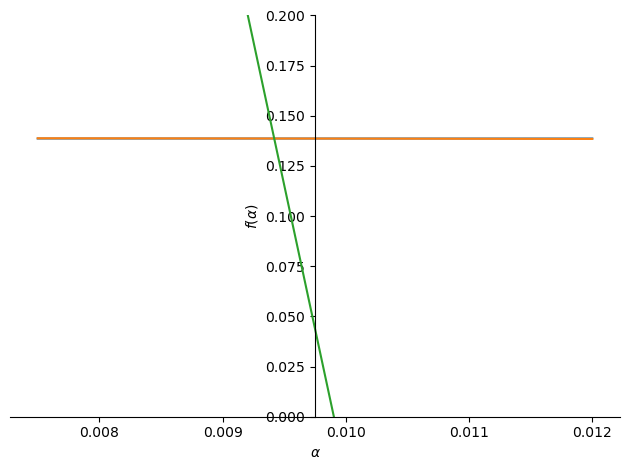

Matrix([[0.00941906322919668], [0.138680920693219]])
Matrix([[0.00941906322919645], [0.138680920693219]])
Matrix([[0.00941906322919645], [0.138680920693219]])
alpha_f = 0.539672569999821 degrees
2theta = 82.0284759948066 degrees


In [12]:
import numpy as np
import sympy as sym
import matplotlib.pylab as plt

d = 14
y = 100
z = 1
incident = 0.2 * np.pi / 180.

# Define equations
sym.var("twotheta, alpha")
eq1 = sym.Eq(twotheta, sym.sec(incident) * sym.sec(alpha) * (d / sym.sqrt(d * d + y * y + z * z) + sym.sin(incident) * sym.sin(alpha)))
eq2 = sym.Eq(twotheta, sym.sqrt(1 - (y * sym.sec(alpha) / sym.sqrt(d * d + y * y + z * z)) ** 2))
eq3 = sym.Eq(twotheta, sym.csc(incident) * sym.sec(alpha) * (z / sym.sqrt(d * d + y * y + z * z) - sym.cos(incident) * sym.sin(alpha)))

# Plot
sym.plot(eq1.rhs, eq2.rhs, eq3.rhs,
         (alpha, 0.0075, 0.012),    # x-limits
         ylim=(0, .2))      # y-limits

s1 = sym.nsolve([eq1, eq2], [alpha, twotheta], [0, 0.5 * np.pi])  # Solve interesection of eq1 and eq2
s2 = sym.nsolve([eq1, eq3], [alpha, twotheta], [0, 0.5 * np.pi])  # Solve interesection of eq1 and eq3
s3 = sym.nsolve([eq2, eq3], [alpha, twotheta], [0, 0.5 * np.pi])  # Solve interesection of eq2 and eq3
alpha_sol, twotheta_sol = sym.nsolve([eq1, eq2, eq3], [alpha, twotheta], [0, 0.5 * np.pi])  # solve overdefined intersection (should all be the same)
print(s1)
print(s2)
print(s3)
print("alpha_f = {} degrees".format(alpha_sol * 180. / np.pi))  # print result in degrees
print("2theta = {} degrees".format(np.arccos(np.array(twotheta_sol, dtype=float)) * 180. / np.pi))  # print result in degrees

In [18]:
def find_angles2(x, y, z, incident):
    incident *= 0.017453292519943295769236907684886     # convert to rads
    tan = np.tan(incident)
    r_inv_len = 1. / np.sqrt(x * x + y * y + z * z)
    sin_alpha = (np.sin(incident) * tan + np.cos(incident)) * (z - x * tan) * r_inv_len
    alpha_f = np.arcsin(sin_alpha)
    twotheta = np.arcsin(y / np.cos(alpha_f) * r_inv_len)
    return alpha_f, twotheta

a, tt = find_angles2(d, y, z, 0.2)
print(a)
print(a * 180 / np.pi)
print(tt * 180 / np.pi)

0.00941917800195249
0.5396791459943452
82.02847643714135


In [13]:
print(np.tan(.2*0.017453292519943295769236907684886))
print(np.sin(.2*0.017453292519943295769236907684886))
print(np.cos(.2*0.017453292519943295769236907684886))


0.00349067268159625
0.003490651415223732
0.9999939076577904


In [45]:
def find_angles(d, y, z, incident):
    """
    Find angles that correspond to a scattered wave hitting a detector a distance d (in mm) away on the screen (y, z) distance away from the beam center on the detector (in mm).
    :param d: sample-detector distance
    :param y: distance in the y-direction a scattered photon hits from the beam center
    :param z: distance in the z-direction a scattered photon hits from the beam center
    :param incident: angle the sample is pitched relative to the beam
    :return: alpha_i, twotheta
    """
    sym.var("twotheta, alpha")
    eq1 = sym.Eq(twotheta, sym.sec(incident) * sym.sec(alpha) * (d / sym.sqrt(d * d + y * y + z * z) + sym.sin(incident) * sym.sin(alpha)))
    eq2 = sym.Eq(twotheta, sym.sqrt(1 - (y * sym.sec(alpha) / sym.sqrt(d * d + y * y + z * z)) ** 2))
    eq3 = sym.Eq(twotheta, sym.csc(incident) * sym.sec(alpha) * (z / sym.sqrt(d * d + y * y + z * z) - sym.cos(incident) * sym.sin(alpha)))

    alpha_sol, twotheta_sol = sym.nsolve([eq1, eq2, eq3], [alpha, twotheta], [0, 0.5 * np.pi])
    return np.array(alpha_sol, dtype=float), np.arccos(np.array(twotheta_sol, dtype=float))

def calc_q_unit(d, y, z, incident):
    """
    Find the q-vector corresponding to a wave hitting a detector d mm away
    :param d: sample-detector distance
    :param y: distance in the y-direction a scattered photon hits from the beam center
    :param z: distance in the z-direction a scattered photon hits from the beam center
    :param incident: angle the sample is pitched relative to the beam
    :return: a unit vector pointing in the direction of q
    """
    alpha, twotheta = find_angles(d, y, z, incident)
    return np.array([
        np.cos(alpha) * np.cos(twotheta) - np.cos(incident),
        np.cos(alpha) * np.sin(twotheta),
        np.sin(incident) + np.sin(alpha)
    ])

def project_q(q):
    """
    Rotate a q vector such that it represents (q_xy, q_z) instead of (q_x, q_y, q_z)
    """
    return np.array([
        np.sqrt(q[0] * q[0] + q[1] * q[1]),
        q[2]
    ])

Text(0.5, 1.0, 'Relationship of q_z and y-direction on detector at constant z position on detector')

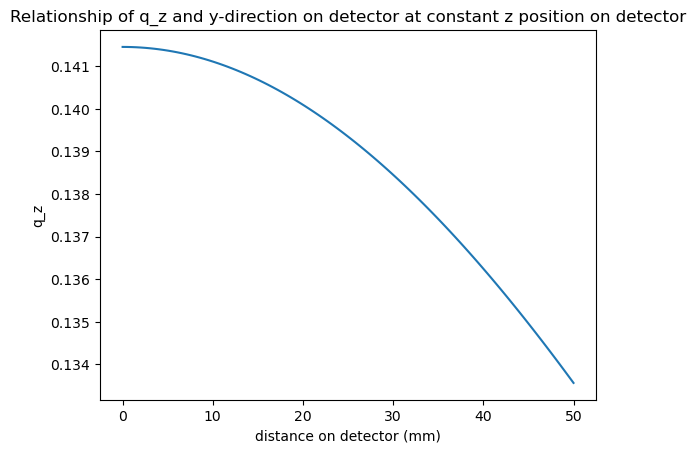

In [48]:
z = 20
ys = np.linspace(0, 50, 100)
incident = 0.2 * np.pi / 180.
d = 140
zps = np.empty(len(ys))

for ii, y in enumerate(ys):
    q = calc_q_unit(d, y, z, incident)
    zps[ii] = q[2]

plt.plot(ys, zps)
plt.xlabel("distance on detector (mm)")
plt.ylabel("q_z")
plt.title("Relationship of q_z and y-direction on detector at constant z position on detector")


In [2]:
import h5py
import numpy as np

# Define dimensions
pixel_size = 75e-6  # meters
rows = 1102
columns = 3070

# Create HDF5 file
with h5py.File("detector.h5", "w") as f:
    # Create dataset for pixel size
    f.create_dataset("pixel_size", data=pixel_size)

    # Create dataset for rows and columns
    f.create_dataset("dimensions", data=(rows, columns))

    # Create dataset for pixel coordinates
    x = np.arange(0, columns) * pixel_size
    y = np.arange(0, rows) * pixel_size
    xx, yy = np.meshgrid(x, y, indexing='ij')
    f.create_dataset("pixel_coordinates/x", data=xx)
    f.create_dataset("pixel_coordinates/y", data=yy)

In [3]:
import h5py
import numpy as np

# Define dimensions
pixel_size = 75e-6  # meters
rows = 1102
columns = 3070

# Create HDF5 file
with h5py.File("detector_pyFAI.h5", "w") as f:
    # Create groups
    f.create_group("detector")
    f.create_group("geometry")

    # Save pixel size
    f["detector"].create_dataset("pixel1", data=pixel_size)
    f["detector"].create_dataset("pixel2", data=pixel_size)

    # Save detector shape
    f["detector"].create_dataset("max_shape", data=(rows, columns))

    # Save detector mask (all pixels active)
    mask = np.ones((rows, columns), dtype=np.int32)
    f["detector"].create_dataset("mask", data=mask)

    # Save pixel positions
    x = np.arange(columns) * pixel_size
    y = np.arange(rows) * pixel_size
    f["geometry"].create_dataset("corner_x", data=x)
    f["geometry"].create_dataset("corner_y", data=y)

print("HDF5 file created successfully.")

HDF5 file created successfully.
